In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import math

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data = pd.read_csv('bank_data_eda.csv')


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees,target,is_new
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new


In [4]:
import pandas as pd
import scipy.stats as stats

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'target']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'target']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'target': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['target'])

            if (
                    abs(r)==1 and                                                        # check if woe for bins are monotonic
                    df_grouped[self.feature].min() > self.bin_min_size                   # check if bin size is greater than 5%
                    and not (df_grouped[self.feature] == df_grouped['target']).any()      # check if number of good and bad is not equal to 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'target']]
    

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='iv', data=df, palette='rocket')
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette='rocket')
        sns.barplot(x=df.index, y='woe_max', data=df, palette='rocket')
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'target': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(8,10))
        sns.set_style("white", {"axes.facecolor": (0, 0, 0, 0)})
        sns.set_style("white", {"legend.facecolor": (0, 0, 0, 0)})
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette='rocket')
        ax.set_title('WOE visualization for: ' + feat.feature, fontsize=14)
        if feat.feature == 'duration' or feat.feature == 'job' or feat.feature == 'education_mod':
            plt.xticks(rotation=90, fontsize=15)
            plt.yticks(fontsize=14)
            ax.set_ylabel('Woe', fontsize=18)
            ax.set_xlabel('')
            plt.show() 
        else:
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=14)
            ax.set_ylabel('Woe', fontsize=18)
            ax.set_xlabel('')
            plt.show()            

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))
        

In [6]:
data['duration'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 41176 entries, 0 to 41175
Series name: duration
Non-Null Count  Dtype
--------------  -----
41176 non-null  int64
dtypes: int64(1)
memory usage: 321.8 KB


In [7]:
iv = IV()
s = StatsSignificance()
ar = AttributeRelevance()

## Discretization

### ContinuousFeature -  this class provides a simple and automated way to bin a continuous feature and generate a dataframe

In [8]:
data['age_mod']=data['age'].apply(lambda x: '17_34' if x<=34 else ('35_44' if x<=44 else ('45_54' if x<=54 else '55plus')))

data['education_mod']=data['education'].map({'university.degree':'university_graduate','high.school':'school_passout','basic.9y':'school_dropout','basic.4y':'school_dropout','basic.6y':'school_dropout','professional.course':'advanced_degree','unknown':'unknown','illiterate':'unknown'})

data = data.drop(['education', 'age'], axis=1)



In [9]:
data.head()

,job,marital,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees,target,is_new,age_mod,education_mod
0,housemaid,married,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,55plus,school_dropout
1,services,married,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,55plus,school_passout
2,services,married,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,35_44,school_passout
3,admin.,married,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,35_44,school_dropout
4,services,married,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,55plus,school_passout


In [10]:
# Continuous
feat_age = CategoricalFeature(data, 'age_mod')

feat_duration = ContinuousFeature(data, 'duration') # not included on the deck

feat_employment_variation_rate = ContinuousFeature(data, 'employment_variation_rate')


## Age

In [11]:
feat_age.df_lite.head()

,bin,target
0,55plus,0
1,55plus,0
2,35_44,0
3,35_44,0
4,55plus,0


In [12]:
iv.group_by_feature(feat_age)

,age_mod,count,good,bad
0,17_34,14751,1922,12829
1,35_44,13495,1168,12327
2,45_54,8702,752,7950
3,55plus,4228,797,3431


### IV & WoE Analysis

In [13]:
iv_df, iv_value = iv.calculate_iv(feat_age)
display(iv_df)
print('Information value: ', iv_value)

,age_mod,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,17_34,14751,1922,12829,0.414313,0.351124,0.063190,0.165485,0.010457
1,35_44,13495,1168,12327,0.251778,0.337384,-0.085606,-0.292672,0.025054
2,45_54,8702,752,7950,0.162104,0.217588,-0.055484,-0.294364,0.016332
3,55plus,4228,797,3431,0.171804,0.093905,0.077899,0.604074,0.047057


Information value:  0.09890086314772521


The percentage of customers of age 16.99 and above that subsribe to the term deposit is 54.4 and customers who did not subscribe is 51%.


The percentage of customers of age 38 and above that subsribe to the term deposit is 45.6 and customers who did not subscribe is 48.9%.

The positive WoE value tells us that the distribution of customer who subscribed is greater than the distribution of customer who did not subscribe

an IV value of 0.0045060613485613625 suggests that age is not a strong predictor of subscribing to a term deposit.

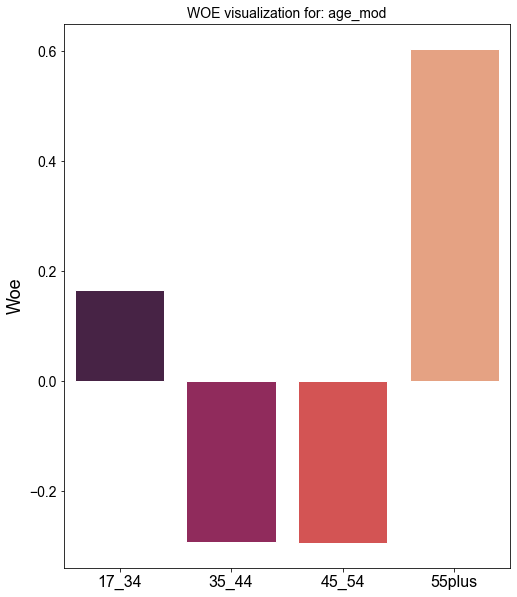

In [14]:

iv.draw_woe(feat_age)

Age feature shows that customer with the age of around 17 and above are more likely to subscribe to the term deposit but as the age goes to 38 and higher then the the customers less likely to subscribe to the term deposit.

This suggests that marketing was popular among young people 
between the age of 16 and 37 because they may be more open to trying out new financial products and are more likely to have less financial responsibilities like paying for mortgages and supporting families.


### statsSignificance

we also want to check the statistical significance of the Age feature. Therefore, we used Chi-Square test of independece of variables and Cramers' v effect size. 

Cramer's V can be interpreted as follows:

1. A value of 0 indicates no association between the variables.
2. A value of 0.1 to 0.3 indicates a weak association.
3. A value of 0.3 to 0.5 indicates a moderate association.
4. A value of 0.5 or greater indicates a strong association.


Cramer's V is useful for interpreting the results of the chi-square test of independence and determining the practical significance of the association between the variables. 

In [15]:
p_value, effect_size = s.calculate_chi(feat_age)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_age)


A feature with effect size: 0.10
P-value: 0.00
Effect size: 0.10
Age_mod is a weak predictor


## Duration

In [16]:
feat_duration.df_lite.head()

,bin,target
0,258.0,0
1,142.0,0
2,202.0,0
3,142.0,0
4,296.0,0


In [17]:
iv.group_by_feature(feat_duration)

,duration,count,good,bad
0,-0.001,2292,1,2291
1,39.000,2350,3,2347
2,63.000,2252,14,2238
3,79.000,2399,43,2356
4,95.000,2216,62,2154
5,110.000,2316,70,2246
6,126.000,2191,92,2099
7,142.000,2323,118,2205
8,160.000,2357,161,2196
9,180.000,2261,171,2090


### IV & WoE Analysis

In [18]:
iv_df, iv_value = iv.calculate_iv(feat_duration)
display(iv_df)
print('Information value: ', iv_value)

,duration,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,2292,1,2291,0.000216,0.062704,-0.062488,-5.672917,0.354489
1,39.000,2350,3,2347,0.000647,0.064236,-0.063590,-4.598454,0.292414
2,63.000,2252,14,2238,0.003018,0.061253,-0.058235,-3.010454,0.175314
3,79.000,2399,43,2356,0.009269,0.064483,-0.055213,-1.939694,0.107097
4,95.000,2216,62,2154,0.013365,0.058954,-0.045589,-1.484121,0.067660
5,110.000,2316,70,2246,0.015089,0.061472,-0.046382,-1.404584,0.065148
6,126.000,2191,92,2099,0.019832,0.057449,-0.037617,-1.063601,0.040009
7,142.000,2323,118,2205,0.025437,0.060350,-0.034913,-0.863972,0.030164
8,160.000,2357,161,2196,0.034706,0.060103,-0.025398,-0.549162,0.013947
9,180.000,2261,171,2090,0.036861,0.057202,-0.020341,-0.439429,0.008938


Information value:  1.9136673804443791


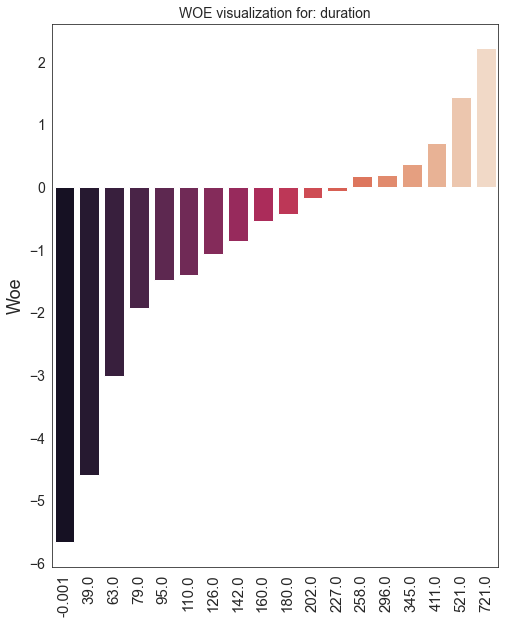

In [19]:
iv.draw_woe(feat_duration)


Customers were more likely to subscribe to the term deposit when their last contact duration was 4.3 minutes or longer, according to duration analysis. It is possible that customers who are more interested in the term deposit may naturally have longer conversations with the bank representative.


### statsSignificance

In [20]:
p_value, effect_size = s.calculate_chi(feat_duration)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_duration)


A feature with effect size: 0.42
P-value: 0.00
Effect size: 0.42
Duration is a strong predictor


## Employee Variation Rate

In [21]:
feat_employment_variation_rate.df_lite.head()


,bin,target
0,-1.8,0
1,-1.8,0
2,-1.8,0
3,-1.8,0
4,-1.8,0


In [22]:
iv.group_by_feature(feat_employment_variation_rate)

,employment_variation_rate,count,good,bad
0,-3.401,12086,2596,9490
1,-1.800,12862,1177,11685
2,1.100,16228,866,15362


### IV & WoE Analysis

In [23]:
iv_df, iv_value = iv.calculate_iv(feat_employment_variation_rate)
display(iv_df)
print('Information value: ', iv_value)

,employment_variation_rate,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-3.401,12086,2596,9490,0.559603,0.259737,0.299867,0.767560,0.230166
1,-1.800,12862,1177,11685,0.253718,0.319813,-0.066094,-0.231511,0.015302
2,1.100,16228,866,15362,0.186678,0.420451,-0.233772,-0.811941,0.189809


Information value:  0.4352763949121961


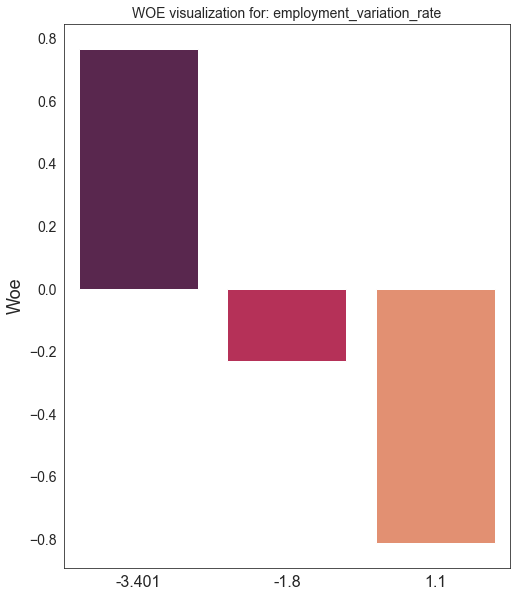

In [24]:
iv.draw_woe(feat_employment_variation_rate)

### statsSignificance

In [25]:
p_value, effect_size = s.calculate_chi(feat_employment_variation_rate)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_employment_variation_rate)

A feature with effect size: 0.21
P-value: 0.00
Effect size: 0.21
Employment_variation_rate is a medium predictor


In [26]:
data.head()

,job,marital,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees,target,is_new,age_mod,education_mod,bin
0,housemaid,married,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,55plus,school_dropout,55plus
1,services,married,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,55plus,school_passout,55plus
2,services,married,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,35_44,school_passout,35_44
3,admin.,married,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,35_44,school_dropout,35_44
4,services,married,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,new,55plus,school_passout,55plus


### CategoricalFeature() -  this class provides a simple and straightforward way to generate a dataframe that summarizes the distribution of a categorical feature and its relationship to the target variable.

There are many methods of imputation like one-hot encoding or simply assigning a number to each class of categorical features, each of these methods have its own merits and demerits. For Logistic Regression, we can use the concept of Weight Of Evidence to impute the categorical features.

In [27]:
feat_job = CategoricalFeature(data, 'job')

feat_marital = CategoricalFeature(data, 'marital')

feat_contact = CategoricalFeature(data, 'contact')

feat_education_mod = CategoricalFeature(data, 'education_mod')

feat_is_new = CategoricalFeature(data, 'is_new')

feat_poutcome = CategoricalFeature(data, 'poutcome')

feat_month = CategoricalFeature(data, 'month')



## Month

In [28]:
feat_month.df_lite.head()

,bin,target
0,may,0
1,may,0
2,may,0
3,may,0
4,may,0


### IV & WoE Analysis

In [29]:
iv_df, iv_value = iv.calculate_iv(feat_month)
display(iv_df)
print('Information value: ', iv_value)

,month,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,apr,2631,539,2092,0.116189,0.057257,0.058932,0.707666,0.041704
1,aug,6176,655,5521,0.141194,0.151107,-0.009913,-0.067852,0.000673
2,dec,182,89,93,0.019185,0.002545,0.016640,2.019863,0.033610
3,jul,7169,648,6521,0.139685,0.178477,-0.038791,-0.245066,0.009506
4,jun,5318,559,4759,0.120500,0.130252,-0.009751,-0.077817,0.000759
5,mar,546,276,270,0.059496,0.007390,0.052106,2.085806,0.108683
6,may,13767,886,12881,0.190989,0.352547,-0.161557,-0.612965,0.099029
7,nov,4100,416,3684,0.089674,0.100829,-0.011155,-0.117243,0.001308
8,oct,717,315,402,0.067903,0.011003,0.056900,1.819947,0.103555
9,sep,570,256,314,0.055184,0.008594,0.046590,1.859611,0.086640


Information value:  0.48546626690111366


an IV value of 0.485 suggests that month is a strong predictor of subscribing to a term deposit.

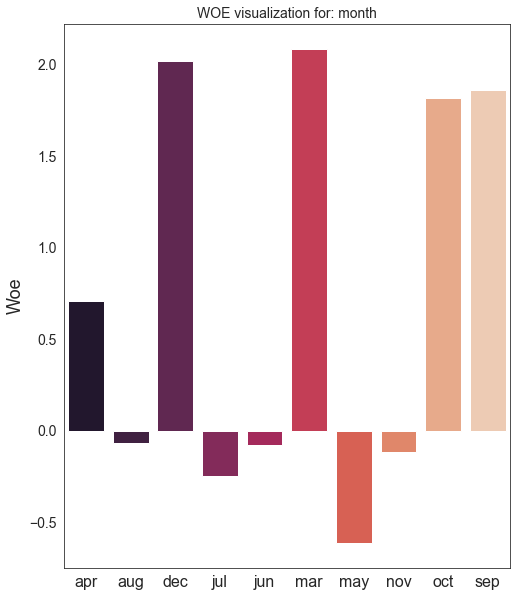

In [30]:
iv.draw_woe(feat_month)


Customers last contacted in April, December, March, October, and September are more likely to subscribe to a term deposit. This could be due to various factors, such as seasonal changes in financial behavior, holiday bonuses, or specific marketing campaigns targeting these months.

Conversely, customers last contacted in August, July, June, May, and November are less likely to subscribe to a term deposit. Again, there could be multiple reasons for this, such as vacations, financial obligations, or lack of effective marketing strategies during these months.

### statsSignificance

In [31]:
p_value, effect_size = s.calculate_chi(feat_month)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_month)


A feature with effect size: 0.27
P-value: 0.00
Effect size: 0.27
Month is a medium predictor


## POUTCOME

In [32]:
feat_poutcome.df_lite.head()

,bin,target
0,nonexistent,0
1,nonexistent,0
2,nonexistent,0
3,nonexistent,0
4,nonexistent,0


In [33]:
iv.group_by_feature(feat_poutcome)

,poutcome,count,good,bad
0,failure,4252,605,3647
1,nonexistent,35551,3140,32411
2,success,1373,894,479


### IV & WoE Analysis

In [34]:
iv_df, iv_value = iv.calculate_iv(feat_poutcome)
display(iv_df)
print('Information value: ', iv_value)

,poutcome,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,failure,4252,605,3647,0.130416,0.099817,0.030599,0.267395,0.008182
1,nonexistent,35551,3140,32411,0.676870,0.887073,-0.210203,-0.270448,0.056849
2,success,1373,894,479,0.192714,0.013110,0.179604,2.687832,0.482745


Information value:  0.5477765054930395


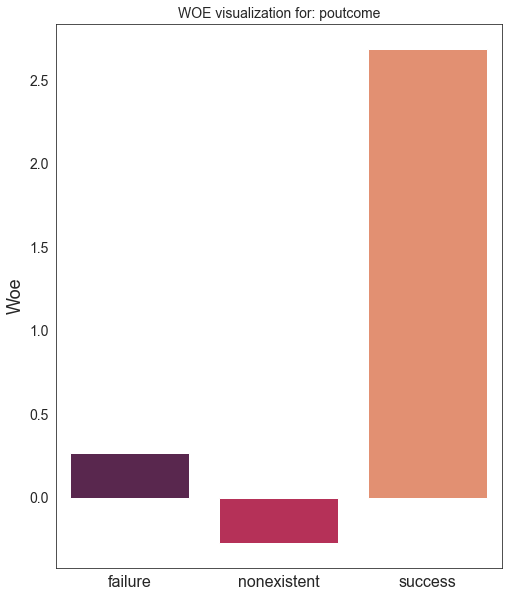

In [35]:
iv.draw_woe(feat_poutcome)

WoE value for the failure and higher success groups is positive, indicating that these groups are more likely to subscribe to a term deposit. This suggests that targeting these groups with future marketing campaigns may be more effective in generating subscriptions than targeting other groups.

### statsSignificance

In [36]:
p_value, effect_size = s.calculate_chi(feat_poutcome)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_poutcome)


A feature with effect size: 0.32
P-value: 0.00
Effect size: 0.32
Poutcome is a medium predictor


## Job

In [37]:
feat_job.df_lite.head()

,bin,target
0,housemaid,0
1,services,0
2,services,0
3,admin.,0
4,services,0


In [38]:
iv.group_by_feature(feat_job)

,job,count,good,bad
0,admin.,10419,1351,9068
1,blue-collar,9253,638,8615
2,entrepreneur,1456,124,1332
3,housemaid,1060,106,954
4,management,2924,328,2596
5,retired,1718,434,1284
6,self-employed,1421,149,1272
7,services,3967,323,3644
8,student,875,275,600
9,technician,6739,730,6009


### IV & WoE Analysis

In [39]:
iv_df, iv_value = iv.calculate_iv(feat_job)
display(iv_df)
print('Information value: ', iv_value)

,job,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,admin.,10419,1351,9068,0.291227,0.248187,0.043040,0.159920,6.882921e-03
1,blue-collar,9253,638,8615,0.137530,0.235788,-0.098259,-0.539095,5.297082e-02
2,entrepreneur,1456,124,1332,0.026730,0.036456,-0.009726,-0.310329,3.018349e-03
3,housemaid,1060,106,954,0.022850,0.026111,-0.003261,-0.133398,4.349795e-04
4,management,2924,328,2596,0.070705,0.071051,-0.000346,-0.004887,1.692657e-06
5,retired,1718,434,1284,0.093555,0.035142,0.058412,0.979136,5.719346e-02
6,self-employed,1421,149,1272,0.032119,0.034814,-0.002695,-0.080573,2.171464e-04
7,services,3967,323,3644,0.069627,0.099735,-0.030107,-0.359358,1.081936e-02
8,student,875,275,600,0.059280,0.016422,0.042858,1.283668,5.501584e-02
9,technician,6739,730,6009,0.157362,0.164463,-0.007102,-0.044142,3.134963e-04


Information value:  0.18878522420109214


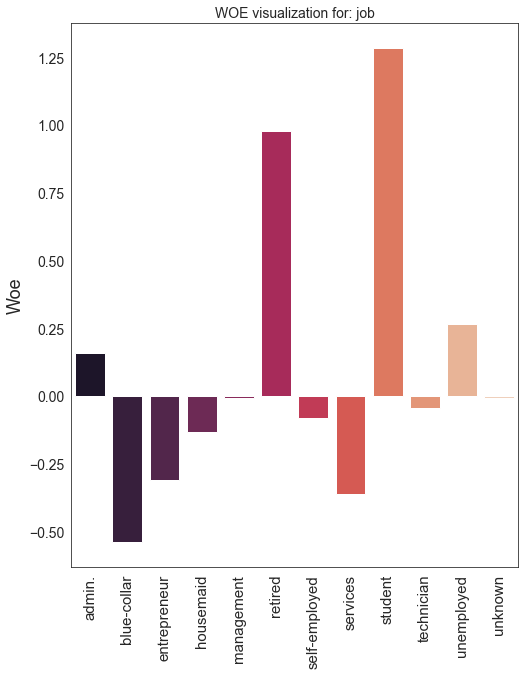

In [40]:
iv.draw_woe(feat_job)


1. Blue-collar, Entrepreneur, Housemaid, Self-employed, Services, and Technician are job categories with negative WoE values, which means that people in these professions are less likely to subscribe to a term deposit. It could be because people in these professions may have lower income levels, making them less likely to save money in long-term deposits.


2. Retired and Unemployed are job categories with high (positive) WoE values, indicating that people in these professions are more likely to subscribe to a term deposit. It could be because people in these professions may have more free time to manage their finances and plan for their future, or may have a higher net worth and are more likely to invest in long-term savings options.


3. Students have a high (positive) WoE value, indicating that they are more likely to subscribe to a term deposit. This could be because they are at a stage in life where they may not have many expenses, making it easier for them to save money.

### statsSignificance

In [41]:
p_value, effect_size = s.calculate_chi(feat_job)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_job)


A feature with effect size: 0.15
P-value: 0.00
Effect size: 0.15
Job is a weak predictor


## Marital

In [42]:
feat_marital.df_lite.head()


,bin,target
0,married,0
1,married,0
2,married,0
3,married,0
4,married,0


In [43]:
iv.group_by_feature(feat_marital)

,marital,count,good,bad
0,divorced,4611,476,4135
1,married,24921,2531,22390
2,single,11564,1620,9944
3,unknown,80,12,68


### IV & WoE Analysis

In [44]:
iv_df, iv_value = iv.calculate_iv(feat_marital)
display(iv_df)
print('Information value: ', iv_value)

,marital,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,divorced,4611,476,4135,0.102608,0.113173,-0.010565,-0.097998,0.001035
1,married,24921,2531,22390,0.545592,0.612803,-0.067212,-0.116173,0.007808
2,single,11564,1620,9944,0.349213,0.272162,0.077051,0.249283,0.019207
3,unknown,80,12,68,0.002587,0.001861,0.000726,0.329226,0.000239


Information value:  0.02828989172554573


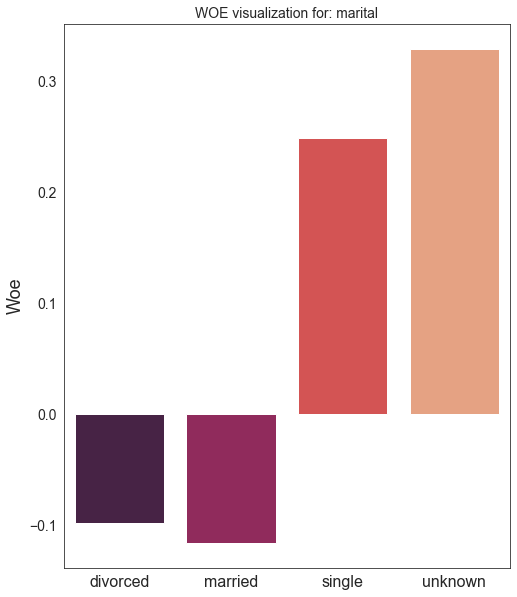

In [45]:
iv.draw_woe(feat_marital)

1. It appears that customers who are divorced or married are less likely to subscribe to the term deposit. This is indicated by a negative WoE, which suggests that these categories have lower predictive power for subscription to term deposits. In contrast, single and unknown customers have a positive WoE, indicating a higher predictive power for subscription to term deposits.


2. This could be because divorced and married customers may have more financial commitments, such as mortgage payments or childcare expenses, which may make it more challenging for them to save or invest in a term deposit. Single and unknown customers, on the other hand, may have more disposable income, making them more likely to invest in term deposits.

### statsSignificance

In [46]:
p_value, effect_size = s.calculate_chi(feat_marital)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_marital)


A feature with effect size: 0.05
P-value: 0.00
Effect size: 0.05
Marital is a useless predictor


## Contact

In [47]:
feat_contact.df_lite.head()


,bin,target
0,telephone,0
1,telephone,0
2,telephone,0
3,telephone,0
4,telephone,0


In [48]:
iv.group_by_feature(feat_contact)

,contact,count,good,bad
0,cellular,26135,3852,22283
1,telephone,15041,787,14254


### IV & WoE Analysis

In [49]:
iv_df, iv_value = iv.calculate_iv(feat_contact)
display(iv_df)
print('Information value: ', iv_value)

,contact,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,cellular,26135,3852,22283,0.830351,0.609875,0.220476,0.308595,0.068038
1,telephone,15041,787,14254,0.169649,0.390125,-0.220476,-0.832738,0.183599


Information value:  0.2516370535802975


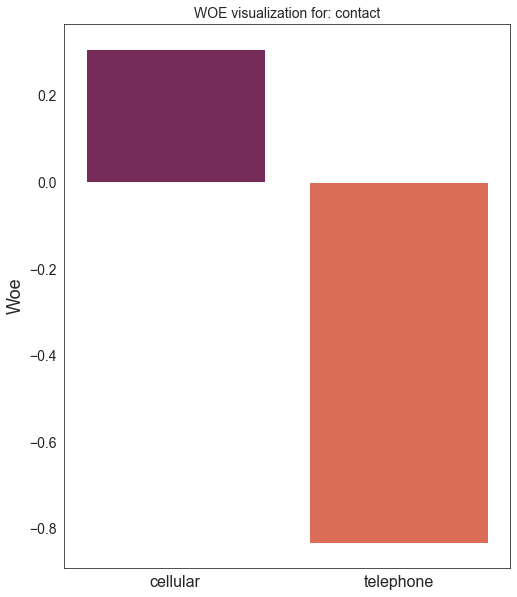

In [50]:
iv.draw_woe(feat_contact)


1. WoE value for cellular is positive suggests that customers who are contacted through cellular are more likely to subscribe to a term deposit, while the fact that the WoE value for telephone is negative suggests that customers who are contacted through telephone are less likely to subscribe to a term deposit.



2. However, it is important to note that WoE alone is not sufficient to determine the causal relationship between the predictor variable and the target variable. Other factors may be at play, such as the characteristics of the customers who are more likely to use cellular or telephone, or the specific messaging used in the different modes of contact. Therefore, while WoE can provide valuable insights into the predictive power of different variables, it should be used in conjunction with other analytical techniques to develop a more nuanced understanding of the relationship between variables.

### statsSignificance

In [51]:
p_value, effect_size = s.calculate_chi(feat_contact)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_contact)


A feature with effect size: 0.14
P-value: 0.00
Effect size: 0.14
Contact is a weak predictor


## Education

In [52]:
feat_education_mod.df_lite.head()


,bin,target
0,school_dropout,0
1,school_passout,0
2,school_passout,0
3,school_dropout,0
4,school_passout,0


In [53]:
iv.group_by_feature(feat_education_mod)

,education_mod,count,good,bad
0,advanced_degree,5240,595,4645
1,school_dropout,12512,1089,11423
2,school_passout,9512,1031,8481
3,university_graduate,12164,1669,10495
4,unknown,1748,255,1493


### IV & WoE Analysis

In [54]:
iv_df, iv_value = iv.calculate_iv(feat_education_mod)
display(iv_df)
print('Information value: ', iv_value)

,education_mod,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,advanced_degree,5240,595,4645,0.128260,0.127131,0.001129,0.008841,0.000010
1,school_dropout,12512,1089,11423,0.234749,0.312642,-0.077893,-0.286542,0.022320
2,school_passout,9512,1031,8481,0.222246,0.232121,-0.009875,-0.043473,0.000429
3,university_graduate,12164,1669,10495,0.359776,0.287243,0.072533,0.225152,0.016331
4,unknown,1748,255,1493,0.054969,0.040863,0.014106,0.296547,0.004183


Information value:  0.043272968019305615


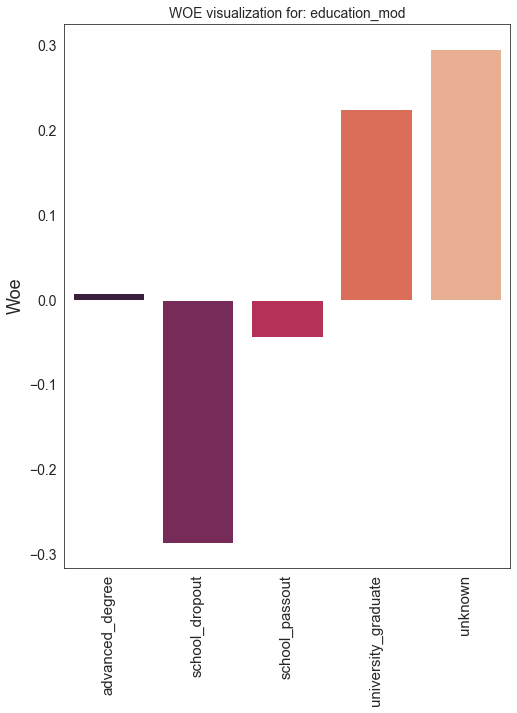

In [55]:
iv.draw_woe(feat_education_mod)


Customers with lower levels of education, such as school dropouts and passouts, are less likely to subscribe to a term deposit. This could be due to various reasons, such as lower income levels or lack of financial literacy. 

Conversely, customers with higher levels of education, such as those with advanced degrees or university graduates, are more likely to subscribe to a term deposit. This could be because they have a better understanding of the benefits of saving and investing.

### statsSignificance

In [56]:
p_value, effect_size = s.calculate_chi(feat_education_mod)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_education_mod)

A feature with effect size: 0.07
P-value: 0.00
Effect size: 0.07
Education_mod is a useless predictor


## Is New Customer

In [57]:
feat_is_new.df_lite.head()


,bin,target
0,new,0
1,new,0
2,new,0
3,new,0
4,new,0


In [58]:
iv.group_by_feature(feat_is_new)

,is_new,count,good,bad
0,new,35551,3140,32411
1,old,5625,1499,4126


### IV & WoE Analysis

In [59]:
iv_df, iv_value = iv.calculate_iv(feat_is_new)
display(iv_df)
print('Information value: ', iv_value)

,is_new,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,new,35551,3140,32411,0.67687,0.887073,-0.210203,-0.270448,0.056849
1,old,5625,1499,4126,0.32313,0.112927,0.210203,1.051316,0.220990


Information value:  0.2778394214582765


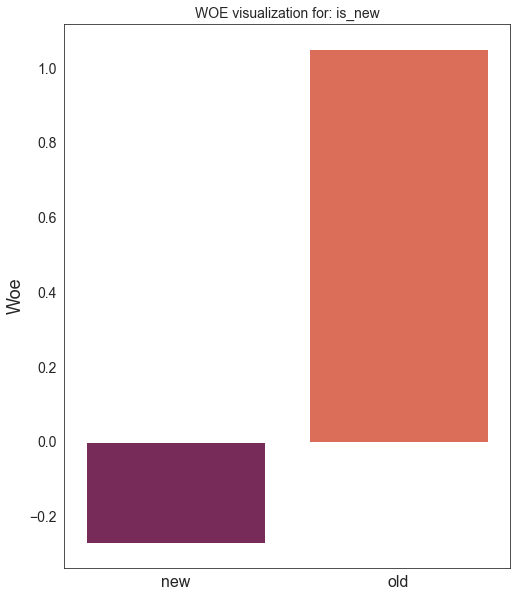

In [60]:
iv.draw_woe(feat_is_new)


A positive WoE value for the "is_new" feature suggests that old customers are more likely to subscribe to a term deposit than new customers. Conversely, a negative WoE value indicates that new customers are less likely to subscribe to a term deposit than old customers.


This information can be useful for developing a targeted marketing strategy to increase the subscription rate of term deposits. For example, if the bank wants to focus on attracting new customers to subscribe to term deposits, they could offer special promotions or discounts to incentivize new customers to sign up.


Conversely, if the bank wants to focus on retaining existing customers, they could offer exclusive benefits or personalized services to reward their loyalty and encourage them to continue using the bank's products and services.



### statsSignificance

In [61]:
p_value, effect_size = s.calculate_chi(feat_is_new)
print('A feature with effect size: %0.2f' % effect_size)
s.print_chi(feat_is_new)


A feature with effect size: 0.19
P-value: 0.00
Effect size: 0.19
Is_new is a weak predictor


In [62]:
feats_dict = {}

for col in [c for c in data.columns if c != 'target']:
    if is_numeric_dtype(data[col]):
        feats_dict[col] = ContinuousFeature(data, col)
    else:
        feats_dict[col] = CategoricalFeature(data, col)

feats = list(feats_dict.values())

this code is used to calculate and display the Information Value for a single feature. The iv_df DataFrame contains more detailed information about each category or bin within the feature, while the iv_value scalar provides a summary measure of the overall predictive power of the feature.

### Attribute Relevance Class

In [63]:
ar = AttributeRelevance()
ar.bulk_iv(feats, iv).head()

/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv
job,0.188785
marital,0.028290
default,0.127787
housing,0.001397
loan,0.000270


In [64]:
ar.bulk_iv(feats, iv, woe_extremes=True).head()

/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,woe_min,woe_max
job,0.188785,-0.539095,1.283668
marital,0.028290,-0.116173,0.329226
default,0.127787,-0.848745,0.152238
housing,0.001397,-0.046670,0.035112
loan,0.000270,-0.046670,0.007480


In [65]:
ar.bulk_stats(feats, s).head()


,p-value,effect_size
job,3.268412e-199,0.152830
marital,1.778423e-26,0.054646
default,5.217541e-89,0.099366
housing,5.663793e-02,0.011809
loan,5.771532e-01,0.005167


In [66]:
ar.analyze(feats, iv).head()


/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv
duration,1.913667
poutcome,0.547777
month,0.485466
employment_variation_rate,0.435276
euribor_3_month_rate,0.348373


In [67]:
ar.analyze(feats, iv, s).head()


/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,p-value,effect_size
duration,1.913667,0.000000e+00,0.420476
poutcome,0.547777,0.000000e+00,0.320520
month,0.485466,0.000000e+00,0.274518
employment_variation_rate,0.435276,0.000000e+00,0.214210
euribor_3_month_rate,0.348373,3.474881e-278,0.175632


In [68]:
df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)

/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,p-value,effect_size,iv_interpretation,es_interpretation
duration,1.913667,0.000000e+00,0.420476,suspicious,strong
poutcome,0.547777,0.000000e+00,0.320520,suspicious,medium
month,0.485466,0.000000e+00,0.274518,strong,medium
employment_variation_rate,0.435276,0.000000e+00,0.214210,strong,medium
euribor_3_month_rate,0.348373,3.474881e-278,0.175632,strong,weak
number_of_employees,0.342291,3.951258e-279,0.175933,strong,weak
is_new,0.277839,0.000000e+00,0.193411,medium,weak
contact,0.251637,1.718741e-189,0.144694,medium,weak
job,0.188785,3.268412e-199,0.152830,medium,weak
default,0.127787,5.217541e-89,0.099366,medium,useless


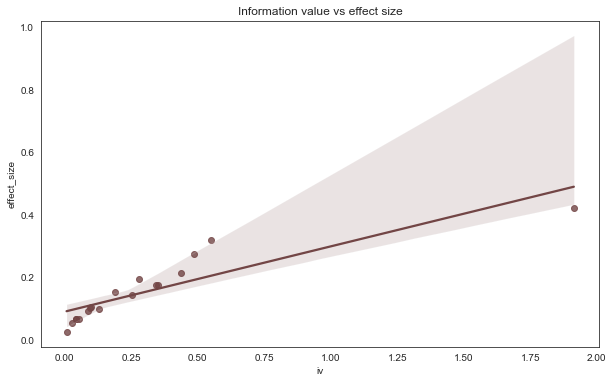

Pearson correlation: 0.88
Spearman correlation: 0.98


In [69]:
df_analysis_sign = df_analysis[df_analysis['p-value']<0.05]

fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='iv', y='effect_size', data=df_analysis_sign, color='#724545')
ax.set_title('Information value vs effect size')
plt.show()

print('Pearson correlation: %0.2f' % df_analysis_sign['iv'].corr(df_analysis_sign['effect_size']))
print('Spearman correlation: %0.2f' % df_analysis_sign['iv'].corr(df_analysis_sign['effect_size'], method='spearman'))

There is strong, almost linear, relationship between information value and effect size. Features with high information value have high effect size as well. Correlation coefficient for these values is: 0.88 (Pearson) and 0.99 (Spearman).

In [70]:
ar.analyze(feats, iv, s, interpretation=True).head()


/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,p-value,effect_size,iv_interpretation,es_interpretation
duration,1.913667,0.000000e+00,0.420476,suspicious,strong
poutcome,0.547777,0.000000e+00,0.320520,suspicious,medium
month,0.485466,0.000000e+00,0.274518,strong,medium
employment_variation_rate,0.435276,0.000000e+00,0.214210,strong,medium
euribor_3_month_rate,0.348373,3.474881e-278,0.175632,strong,weak


/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


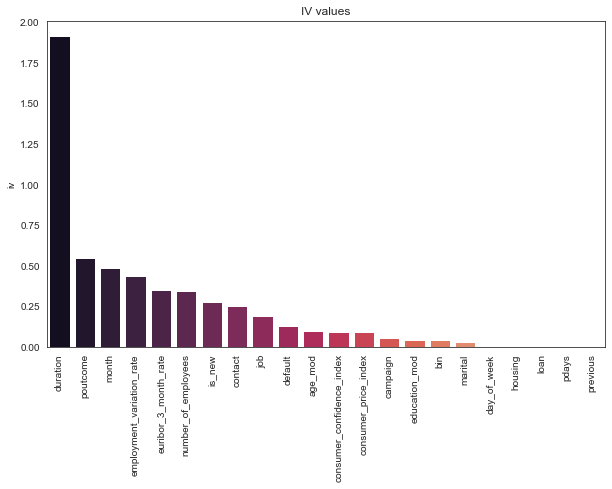

In [71]:
ar.draw_iv(feats, iv)

/Users/kajalshukla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


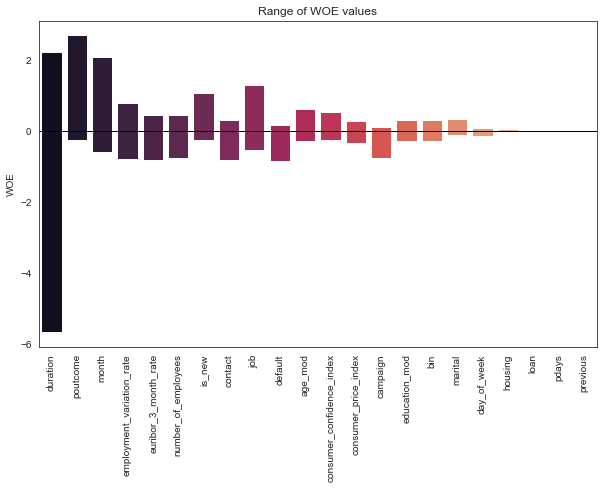

In [72]:
ar.draw_woe_extremes(feats, iv)
